<h1 align='center'><b>Машинное обучение в бизнесе<b></h1>

<h1 align='left'>Урок 5. Задача оттока: варианты постановки, возможные способы решения</h1>

<h2 align='center'>Домашняя работа</h2>

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
# !pip install --upgrade pip
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install mplcyberpunk
# !pip install matplotlib
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd
import itertools

# Visual libraries
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
import mplcyberpunk

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
# sns.set(font_scale=1.5)
plt.style.use('cyberpunk')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier



In [3]:
RANDOM_STATE = 42

In [4]:
df = pd.read_csv('./data/churn_data.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить.

Посмотрим на распределение классов целевой переменной:

In [5]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [7]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [8]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [9]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
    ])
    final_transformers.append((cat_col, cat_transformer))

# в данном случае над вещественными признаками преобразований не производится.
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('standart', StandardScaler())
    ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feast', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

### __RandomForestClassifier__

In [12]:
pipeline_rf = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE)),
])

Обучим модель

In [13]:
#обучим наш пайплайн
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [14]:
#наши прогнозы для тестовой выборки
preds_rf = pipeline_rf.predict_proba(X_test)[:, 1]
preds_rf[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [15]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test, preds_rf)
roc_auc = roc_auc_score(y_true=y_test, y_score=preds_rf)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, Precision=%.3f, Recall=%.3f, Roc_Auc=%.3f, F-Score=%.3f' % (thresholds[ix],
                                                                                      precision[ix],
                                                                                      recall[ix],
                                                                                      roc_auc,
                                                                                      fscore[ix]))
threshold_rf = thresholds[ix],
precision_rf = precision[ix],
recall_rf = recall[ix],
roc_auc_rf = roc_auc,
fscore_rf = fscore[ix]

Best Threshold=0.380000, Precision=0.654, Recall=0.629, Roc_Auc=0.864, F-Score=0.641


Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629

### __LogisticRegression__

In [16]:
pipeline_lr = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE)),
])

In [17]:
#обучим наш пайплайн
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [18]:
#наши прогнозы для тестовой выборки
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]
preds_lr[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [19]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test, preds_lr)
roc_auc = roc_auc_score(y_true=y_test, y_score=preds_lr)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, Precision=%.3f, Recall=%.3f, Roc_Auc=%.3f, F-Score=%.3f' % (thresholds[ix],
                                                                                      precision[ix],
                                                                                      recall[ix],
                                                                                      roc_auc,
                                                                                      fscore[ix]))
threshold_lr = thresholds[ix],
precision_lr = precision[ix],
recall_lr = recall[ix],
roc_auc_lr = roc_auc,
fscore_lr = fscore[ix]

Best Threshold=0.289522, Precision=0.462, Recall=0.568, Roc_Auc=0.772, F-Score=0.510


### __Catboost__

CatBoost славится своей способностью хорошо работать с категориальными признаками. Но для чистоты эксперимента не будем выделять их отдельно.

In [20]:
pipeline_cb = Pipeline([
    ('features', feats),
    ('classifier', CatBoostClassifier(random_state=RANDOM_STATE, verbose=False,))
])

In [21]:
#обучим наш пайплайн
pipeline_cb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [22]:
#наши прогнозы для тестовой выборки
preds_cb = pipeline_cb.predict_proba(X_test)[:, 1]
preds_cb[:10]

array([0.46917705, 0.24499582, 0.11518556, 0.04942908, 0.02369729,
       0.87775373, 0.02032456, 0.13019025, 0.16192791, 0.91391094])

In [23]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test, preds_cb)
roc_auc = roc_auc_score(y_true=y_test, y_score=preds_cb)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, Precision=%.3f, Recall=%.3f, Roc_Auc=%.3f, F-Score=%.3f' % (thresholds[ix],
                                                                                      precision[ix],
                                                                                      recall[ix],
                                                                                      roc_auc,
                                                                                      fscore[ix]))
threshold_cb = thresholds[ix],
precision_cb = precision[ix],
recall_cb = recall[ix],
roc_auc_cb = roc_auc,
fscore_cb = fscore[ix]

Best Threshold=0.384476, Precision=0.661, Recall=0.629, Roc_Auc=0.877, F-Score=0.645


### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [24]:
summary_table = pd.DataFrame({
    'Model': ['RandomForestClassifier', 'LogisticRegression', 'CatBoost'],
    'Threshold': [threshold_rf, threshold_lr, threshold_cb],
    'Precision': [precision_rf, precision_lr, precision_cb],
    'Recall': [recall_rf, recall_lr, recall_cb],
    'ROC-AUC': [roc_auc_rf, roc_auc_lr, roc_auc_cb],
    'F-Score': [fscore_rf, fscore_lr, fscore_cb],
})
summary_table

,Model,Threshold,Precision,Recall,ROC-AUC,F-Score
0,RandomForestClassifier,"(0.38,)","(0.65439672801636,)","(0.6286836935166994,)","(0.8636990228128739,)",0.641283
1,LogisticRegression,"(0.28952195521707996,)","(0.4624,)","(0.5677799607072691,)","(0.7720774921330664,)",0.509700
2,CatBoost,"(0.3844764867775179,)","(0.6611570247933884,)","(0.6286836935166994,)","(0.8766127337261289,)",0.644512


Выбирал между ROC-AUC и F-Score. Остановился на F-Score, т. к., во-первых, у нас есть дисбаланс 1:4, который может влиять на точность  ROC-AUC, а, во-вторых,  F-Score является гармоничным средним между точностью и полнотой. Следовательно, даёт возможность придавать приоритет либо первому, либо второму, в зависимости от конкретной ситуации или задачи бизнеса.

__Вывод:__
По итогам сравнения F-Score, лучше себя показала модель CatBoost.


### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

Для того, чтобы модель была потенциально экономически эффективной, нужно, чтобы доход от всех удержанных клиентов (TP) перекрывал затрата на их удержание, с учётом тех клиентов, на которым модель ошиблась (TP + FP).

Отрисуем матрицу ошибок

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1827  164]
 [ 190  319]]


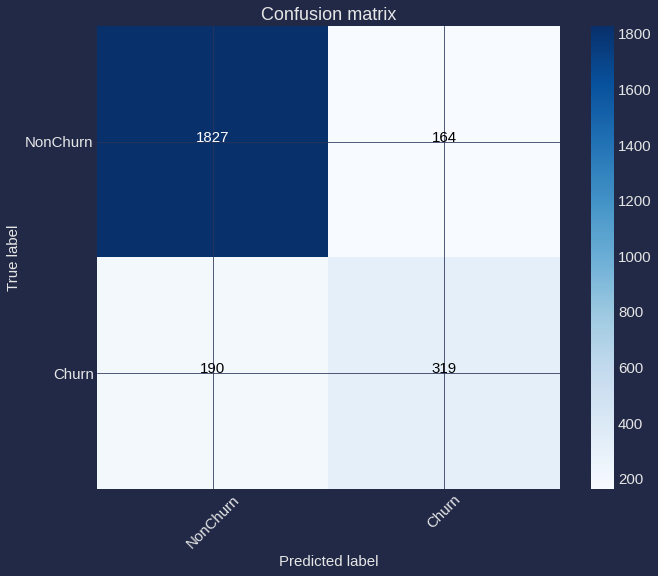

In [26]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_cb>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [27]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TN, FN, TP, FP

(1827, 190, 319, 164)

In [28]:
# в соответствии с исходными данными:
attraction_cost = 1
income = 2

In [29]:
attraction_cost_sum = (TP + FP) * attraction_cost
income_sum = TP * income

profit = income_sum - attraction_cost_sum
print(f'Прибыль от работы модели составляет: {profit}$')

Прибыль от работы модели составляет: 155$


__Вывод:__  
Модель даёт положительный результат. Прибыль от удержания клиентов, за вычетом затрат на их удержание (в т.ч. тех, на которых модель ошиблась), составит 155 $.
Но сказать, что модель экономически эффективна, ИМХО, может только бизнес.

### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

Сетка с параметрами

In [30]:
grid_params={
#     'classifier__reg_lambda': [1, 2, 3],
    'classifier__learning_rate': [0.03, 0.1],
    'classifier__depth': [2, 3, 4],
    'classifier__iterations': [500, 1000, 1500],
    'classifier__random_strength':[3, 5, 7, 10]
}

Запускаем перебор

In [31]:
# %%time

# grid = GridSearchCV(pipeline_cb,
#                     param_grid=grid_params,
#                     cv=6,
#                     refit=False,
#                     verbose=0,
#                     n_jobs=-1)

# search = grid.fit(X_train, y_train)
# search.best_params_

In [32]:
# best_params = search.best_params_
# best_params

Wall time: 18min 36s
{'classifier__depth': 4,
 'classifier__iterations': 500,
 'classifier__learning_rate': 0.03,
 'classifier__random_strength': 5}

Обучаем модель уже сновыми параметрами

In [33]:
pipeline_tuned = Pipeline([
    ('features', feats),
    ('classifier', CatBoostClassifier(random_state=RANDOM_STATE,
                                      iterations=500,
                                      depth=4,
                                      od_wait=20,
                                      learning_rate=0.03,
                                      verbose=False,
                                      random_strength=7.3)),
])
pipeline_tuned.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

### 5. (опционально) Еще раз провести оценку экономической эффективности

Best Threshold=0.367529, Precision=0.674, Recall=0.640, Roc_Auc=0.880, F-Score=0.657
Confusion matrix, without normalization
[[1833  158]
 [ 184  325]]


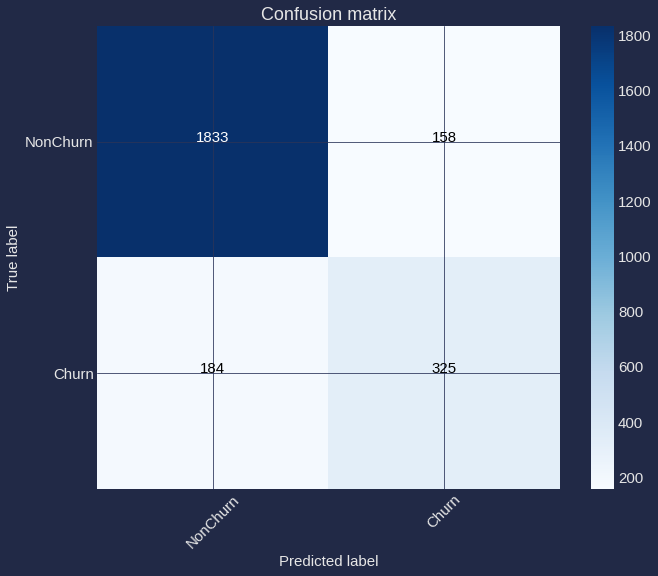

In [34]:
preds_cb_tuned = pipeline_tuned.predict_proba(X_test)[:, 1]

b=1
precision, recall, thresholds = precision_recall_curve(y_test, preds_cb_tuned)
roc_auc = roc_auc_score(y_true=y_test, y_score=preds_cb_tuned)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, Precision=%.3f, Recall=%.3f, Roc_Auc=%.3f, F-Score=%.3f' % (thresholds[ix],
                                                                                      precision[ix],
                                                                                      recall[ix],
                                                                                      roc_auc,
                                                                                      fscore[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_cb_tuned>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [35]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TN, FN, TP, FP

(1833, 184, 325, 158)

In [36]:
attraction_cost_sum = (TP + FP) * attraction_cost
income_sum = TP * income

profit = income_sum - attraction_cost_sum
print(f'Прибыль от работы модели составляет: {profit}$')

Прибыль от работы модели составляет: 167$


__Вывод:__  
После подбора гиперпараметров модель показала себя немного лучше. Она также даёт положительный результат. Прибыль от удержания клиентов, за вычетом затрат на их удержание (в т.ч. тех, на которых модель ошиблась), составляет 167 $.  
Но сказать, что модель экономически эффективна, ИМХО, может только бизнес.